In [1]:
from mftool import Mftool
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from yahooquery import Ticker
import datetime
from dateutil.relativedelta import relativedelta
from jugaad_data.nse import index_raw

%matplotlib inline

In [2]:
def fetch_index_data(index, start_date='1-1-2019', end_date='31-12-2023'):
    
    def convert_to_date(date_str):
        date_obj = datetime.datetime.strptime(date_str, '%d %b %Y')
        return date_obj

    # Get from and to dates
    from_date = datetime.datetime.strptime(start_date, '%d-%m-%Y').date()
    to_date = datetime.datetime.strptime(end_date, '%d-%m-%Y').date()
    
    # Pull data
    raw_index_data = index_raw(symbol=index, from_date=from_date, to_date=to_date)
    df = (pd.DataFrame(raw_index_data)\
            .assign(HistoricalDate=lambda x: x['HistoricalDate'].apply(convert_to_date),
                    CLOSE=lambda x: x['CLOSE'].astype(float),
                    INDEX_NAME = lambda x: x['INDEX_NAME'].str.upper())\
            .sort_values('HistoricalDate')\
            .drop_duplicates()\
            .loc[lambda x: x['INDEX_NAME'] == index]\
            .reset_index(drop=True)\
            .rename(columns={'HistoricalDate':'date'})
                       )
    df = df.loc[~df.duplicated(subset=['date'], keep='first')]
    return df


In [3]:
def fetch_mutual_fund_data(mutual_fund_code):
    mf = Mftool()
    
    df = (mf.get_scheme_historical_nav(mutual_fund_code,as_Dataframe=True).reset_index()\
          .assign(nav=lambda x: x['nav'].astype(float), 
                 date=lambda x: pd.to_datetime(x['date'], format='%d-%m-%Y'))\
          .sort_values('date')\
          .reset_index(drop=True)\
         )
    
    return df

In [4]:
def get_cumulative_returns(df, 
                         nav_col='CLOSE', 
                         date_col='date',
                         starting_date='1-1-2019', 
                         ending_date ='31-12-2023'):
    start_date = pd.to_datetime(starting_date, format='%d-%m-%Y')
    end_date = pd.to_datetime(ending_date, format='%d-%m-%Y')
    
    df = (df\
          .sort_values(date_col)\
          .query(f"{date_col} >= @start_date and {date_col} <=@end_date")\
          .assign(daily_returns=lambda x: x[nav_col].pct_change(),
                  cumulative_daily_returns=lambda x: (x['daily_returns'] + 1).cumprod())\
          .reset_index(drop=True)\
         )
    
    return df

In [104]:
# nifty_indices = ["NIFTY 500", "NIFTY 50", "NIFTY MIDCAP 150", "NIFTY SMALLCAP 250", "NIFTY 200", "NIFTY 100"]
nifty_indices = ["NIFTY 500",]

nifty_indices_df_dict = {index: fetch_index_data(index) for index in nifty_indices}

In [6]:
# Fetch data for these funds
mutual_funds = {'120819': 'quant Absolute Fund-Growth Option-Direct Plan',
 '120828': 'quant Small Cap Fund - Growth Option - Direct Plan',
 '119063': 'HDFC Index Fund-NIFTY 50 Plan - Direct Plan',
 '118955': 'HDFC Flexi Cap Fund - Growth Option - Direct Plan',
 '118269': 'CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT PLAN - GROWTH OPTION',
 '122639': 'Parag Parikh Flexi Cap Fund - Direct Plan - Growth',
 '125307': 'PGIM India Midcap Opportunities Fund - Direct Plan - Growth Option', 
 '146271': 'Nippon India ETF Nifty Midcap 150', 
 '147704': 'Motilal Oswal Large and Midcap Fund - Direct Plan Growth',
}

mf_data_dict = dict()
for mutual_fund_code, mutual_fund_desc in mutual_funds.items():
    print(mutual_fund_desc)
    mf_data_dict[mutual_fund_desc] = fetch_mutual_fund_data(mutual_fund_code)

quant Absolute Fund-Growth Option-Direct Plan
quant Small Cap Fund - Growth Option - Direct Plan
HDFC Index Fund-NIFTY 50 Plan - Direct Plan
HDFC Flexi Cap Fund - Growth Option - Direct Plan
CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT PLAN - GROWTH OPTION
Parag Parikh Flexi Cap Fund - Direct Plan - Growth
PGIM India Midcap Opportunities Fund - Direct Plan - Growth Option
Nippon India ETF Nifty Midcap 150
Motilal Oswal Large and Midcap Fund - Direct Plan Growth


## Let's look at only Flexi Cap funds for the analysis

In [22]:
results_wide_dict = dict()
results_long_dict = dict()

## 1. Performance at a cumulated yearly level or CAGR

How has the fund performed across 1yr, 3yr, 5 yr horizon?

2 ways of doing this: 
1. Tracking the journey of investment - Indicative of the nonlinear journey
2. Tracking like Mutual Fund Screeners

### 1.1 Calculate cumulative returns and growth % - Journey of Invested Amount

This is going to be slightly different than what we see on the mutual fund screeners. 
We will start from 2019 and then calculate 1,2,...5 yr returns. 

For a 3yr returns, it will answer: If a person invested in 2019, what would be the 3yr value investment in 2021 DEC?

It is the journey of how investor's money goes up/down if it was invested in a particular year and thereafter.

In [60]:
# time_periods = {
#     1: '1-1-2023', 
#     2: '1-1-2022', 
#     3: '1-1-2021',
#     4: '1-1-2020',
#     5: '1-1-2019',
# }

time_periods = {
    5: ('1-1-2019', '31-12-2023'), 
    4: ('1-1-2019', '31-12-2022'),
    3: ('1-1-2019', '31-12-2021'),
    2: ('1-1-2019', '31-12-2020'),
    1: ('1-1-2019', '31-12-2019'),
}

results = []
time_period_dataframes = {time_period: dict() for time_period in time_periods}

# Mutual Funds data
mutual_funds_subset = [
 'HDFC Flexi Cap Fund - Growth Option - Direct Plan',
 'Parag Parikh Flexi Cap Fund - Direct Plan - Growth',
]

for instrument_desc in mutual_funds_subset: 
    for time_period, (starting_date, ending_date) in time_periods.items():
        n_years = time_period
        mutual_fund_data = mf_data_dict[instrument_desc].copy(deep=True)
        mf_with_cumulative = get_cumulative_returns(mutual_fund_data, 
                                                           nav_col='nav', 
                                                           date_col='date',
                                                           starting_date=starting_date, 
                                                           ending_date=ending_date)
        absolute_returns_prcnt = (mf_with_cumulative['cumulative_daily_returns'].values[-1] - 1) * 100
        cagr = ((mf_with_cumulative['nav'].iloc[-1]/mf_with_cumulative['nav'].iloc[0]) ** (1/n_years) - 1) * 100

        time_period_dataframes[time_period][instrument_desc] = mf_with_cumulative
        results += [(instrument_desc, time_period, absolute_returns_prcnt, cagr)]
        

## Indices cumulative returns and growth 
nifty_indices = ["NIFTY 500",]
nifty_indices_results = []
time_period_nifty_dataframes = {time_period: dict() for time_period in time_periods}


for index in nifty_indices:
    print(index)
    for time_period, (starting_date, ending_date) in time_periods.items():
        n_years = time_period
        index_df = nifty_indices_df_dict[index].copy(deep=True)
        index_with_cumulative = get_cumulative_returns(index_df, 
                                                           nav_col='CLOSE', 
                                                           date_col='date',
                                                           starting_date=starting_date, 
                                                           ending_date =ending_date)
        absolute_returns_prcnt = (index_with_cumulative['cumulative_daily_returns'].values[-1] - 1) * 100
        cagr = ((index_with_cumulative['CLOSE'].iloc[-1]/index_with_cumulative['CLOSE'].iloc[0]) ** (1/n_years) - 1) * 100

        time_period_nifty_dataframes[time_period][index] = index_with_cumulative
        results += [(index, time_period, absolute_returns_prcnt, cagr)]

NIFTY 500


In [61]:
result_df = pd.DataFrame(results, columns=['Fund', 'Years', 'Abs_returns_prcnt', 'CAGR']).\
pivot(index='Fund', columns='Years', values=['Abs_returns_prcnt', 'CAGR'])
result_df.columns = [f'{x}_{y}' for x, y in result_df.columns]
result_df = result_df.applymap(lambda x: f"{x:.2f}%")
result_df

,Abs_returns_prcnt_1,Abs_returns_prcnt_2,Abs_returns_prcnt_3,Abs_returns_prcnt_4,Abs_returns_prcnt_5,CAGR_1,CAGR_2,CAGR_3,CAGR_4,CAGR_5
Fund,,,,,,,,,,
HDFC Flexi Cap Fund - Growth Option - Direct Plan,6.68%,14.20%,56.45%,86.31%,144.90%,6.68%,6.86%,16.09%,16.83%,19.62%
NIFTY 500,7.33%,25.23%,63.04%,67.96%,111.23%,7.33%,11.91%,17.70%,13.84%,16.13%
Parag Parikh Flexi Cap Fund - Direct Plan - Growth,14.93%,53.49%,125.58%,111.39%,190.97%,14.93%,23.89%,31.15%,20.58%,23.81%


In [62]:
results_long= pd.DataFrame(results, columns=['Fund', 'Years', 'Abs_returns_prcnt', 'CAGR'])
results_long

,Fund,Years,Abs_returns_prcnt,CAGR
0,HDFC Flexi Cap Fund - Growth Option - Direct Plan,5,144.904387,19.618765
1,HDFC Flexi Cap Fund - Growth Option - Direct Plan,4,86.306156,16.830652
2,HDFC Flexi Cap Fund - Growth Option - Direct Plan,3,56.446438,16.088329
3,HDFC Flexi Cap Fund - Growth Option - Direct Plan,2,14.197116,6.863051
4,HDFC Flexi Cap Fund - Growth Option - Direct Plan,1,6.679891,6.679891
5,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,5,190.970585,23.814018
6,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,4,111.393847,20.579391
7,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,3,125.582513,31.150055
8,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,2,53.485135,23.889118
9,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,1,14.930554,14.930554


[]

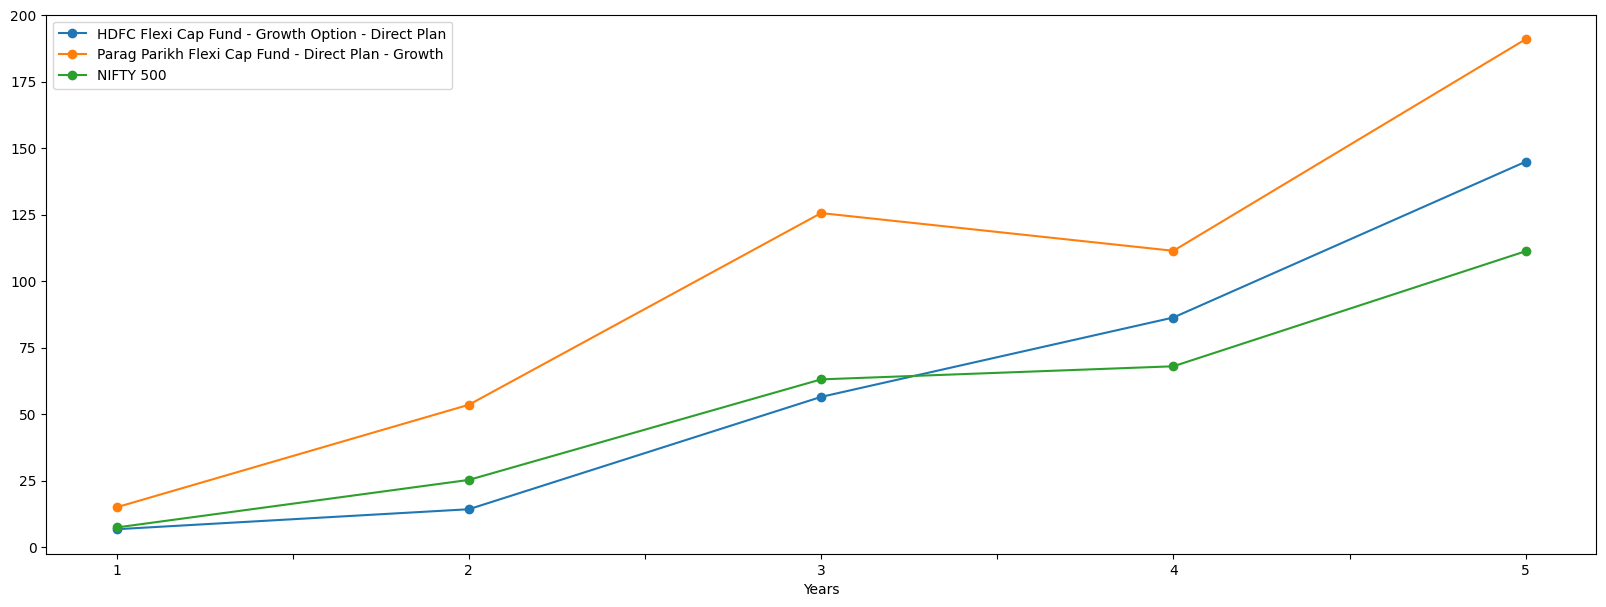

In [63]:
plt.rcParams["figure.figsize"] = [20,7]

def df_process(df):
    df = df.sort_values('Years')
    df['Years'] = df['Years'].astype(str)
    return df

for idx, fund in enumerate(results_long['Fund'].unique()):
    fund_df = results_long.loc[results_year_lvl_long['Fund']==fund]
    fund_df = df_process(fund_df)
    if idx==0:
        ax = fund_df.plot(y='Abs_returns_prcnt', x='Years', label=fund, marker='o',)
    else:
        fund_df.plot(ax=ax, y='Abs_returns_prcnt', x='Years', label=fund, marker='o',)
    
plt.legend(loc='upper left')

plt.plot()

### Findings: 

1. Both funds have high had higher returns than the benchmark
2. HDFC FLexi cap struggled in 2019, 2020 but picked up from 2021 onwards
3. Interesting to note that Abs_returns_prcnt_4 < Abs_returns_prcnt_3 for Parag Parikh fund. This shows that the fund struggled in 2022 but picked up again in 2023. 

While this does show the fund's performance across the years, we can a deep-dive analysis for fund's performance for each individual year. 
1. What was the fund's growth in 2022 compared to fund's growth in 2021? 
2. At an individual year level, how many years was the fund able to beat the benchmark? 


### 1.2 Calculate cumulative returns and growth % - Traditional style
The traditional style: If a person invested in 2021, what would be the 3yr value investment in 2023 DEC?

Gives more importance to the recent years and we will use this analysis hereafter. 

In [105]:
time_periods = {
    5: ('1-1-2019', '31-12-2023'), 
    4: ('1-1-2020', '31-12-2023'),
    3: ('1-1-2021', '31-12-2023'),
    2: ('1-1-2022', '31-12-2023'),
    1: ('1-1-2023', '31-12-2023'),
}

results = []
time_period_dataframes = {time_period: dict() for time_period in time_periods}

# Mutual Funds data
mutual_funds_subset = [
 'HDFC Flexi Cap Fund - Growth Option - Direct Plan',
 'Parag Parikh Flexi Cap Fund - Direct Plan - Growth',
]

for instrument_desc in mutual_funds_subset: 
    for time_period, (starting_date, ending_date) in time_periods.items():
        n_years = time_period
        mutual_fund_data = mf_data_dict[instrument_desc].copy(deep=True)
        mf_with_cumulative = get_cumulative_returns(mutual_fund_data, 
                                                           nav_col='nav', 
                                                           date_col='date',
                                                           starting_date=starting_date, 
                                                           ending_date=ending_date)
        absolute_returns_prcnt = (mf_with_cumulative['cumulative_daily_returns'].values[-1] - 1) * 100
        cagr = ((mf_with_cumulative['nav'].iloc[-1]/mf_with_cumulative['nav'].iloc[0]) ** (1/n_years) - 1) * 100

        time_period_dataframes[time_period][instrument_desc] = mf_with_cumulative
        results += [(instrument_desc, time_period, absolute_returns_prcnt, cagr)]
        

## Indices cumulative returns and growth 
nifty_indices = ["NIFTY 500",]
nifty_indices_results = []
time_period_nifty_dataframes = {time_period: dict() for time_period in time_periods}


for index in nifty_indices:
    print(index)
    for time_period, (starting_date, ending_date) in time_periods.items():
        n_years = time_period
        index_df = nifty_indices_df_dict[index].copy(deep=True)
        index_with_cumulative = get_cumulative_returns(index_df, 
                                                           nav_col='CLOSE', 
                                                           date_col='date',
                                                           starting_date=starting_date, 
                                                           ending_date =ending_date)
        absolute_returns_prcnt = (index_with_cumulative['cumulative_daily_returns'].values[-1] - 1) * 100
        cagr = ((index_with_cumulative['CLOSE'].iloc[-1]/index_with_cumulative['CLOSE'].iloc[0]) ** (1/n_years) - 1) * 100

        time_period_nifty_dataframes[time_period][index] = index_with_cumulative
        results += [(index, time_period, absolute_returns_prcnt, cagr)]

NIFTY 500


In [106]:
result_df = pd.DataFrame(results, columns=['Fund', 'Years', 'Abs_returns_prcnt', 'CAGR']).\
pivot(index='Fund', columns='Years', values=['Abs_returns_prcnt', 'CAGR'])
result_df.columns = [f'{x}_{y}' for x, y in result_df.columns]
result_df = result_df.applymap(lambda x: f"{x:.2f}%")
result_df

,Abs_returns_prcnt_1,Abs_returns_prcnt_2,Abs_returns_prcnt_3,Abs_returns_prcnt_4,Abs_returns_prcnt_5,CAGR_1,CAGR_2,CAGR_3,CAGR_4,CAGR_5
Fund,,,,,,,,,,
HDFC Flexi Cap Fund - Growth Option - Direct Plan,30.67%,54.18%,113.16%,128.64%,144.90%,30.67%,24.17%,28.70%,22.97%,19.62%
NIFTY 500,25.16%,27.78%,67.86%,96.48%,111.23%,25.16%,13.04%,18.84%,18.39%,16.13%
Parag Parikh Flexi Cap Fund - Direct Plan - Growth,37.49%,28.68%,89.30%,152.66%,190.97%,37.49%,13.44%,23.70%,26.08%,23.81%


In [56]:
results_long = pd.DataFrame(results, columns=['Fund', 'Years', 'Abs_returns_prcnt', 'CAGR'])
results_long

,Fund,Years,Abs_returns_prcnt,CAGR
0,HDFC Flexi Cap Fund - Growth Option - Direct Plan,5,144.904387,19.618765
1,HDFC Flexi Cap Fund - Growth Option - Direct Plan,4,128.640534,22.966923
2,HDFC Flexi Cap Fund - Growth Option - Direct Plan,3,113.163330,28.697714
3,HDFC Flexi Cap Fund - Growth Option - Direct Plan,2,54.178086,24.168469
4,HDFC Flexi Cap Fund - Growth Option - Direct Plan,1,30.669438,30.669438
5,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,5,190.970585,23.814018
6,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,4,152.658101,26.076257
7,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,3,89.296292,23.703134
8,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,2,28.678437,13.436518
9,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,1,37.494568,37.494568


In [37]:
results_wide_dict['cumulated'] = result_df
results_long_dict['cumulated'] = results_long

[]

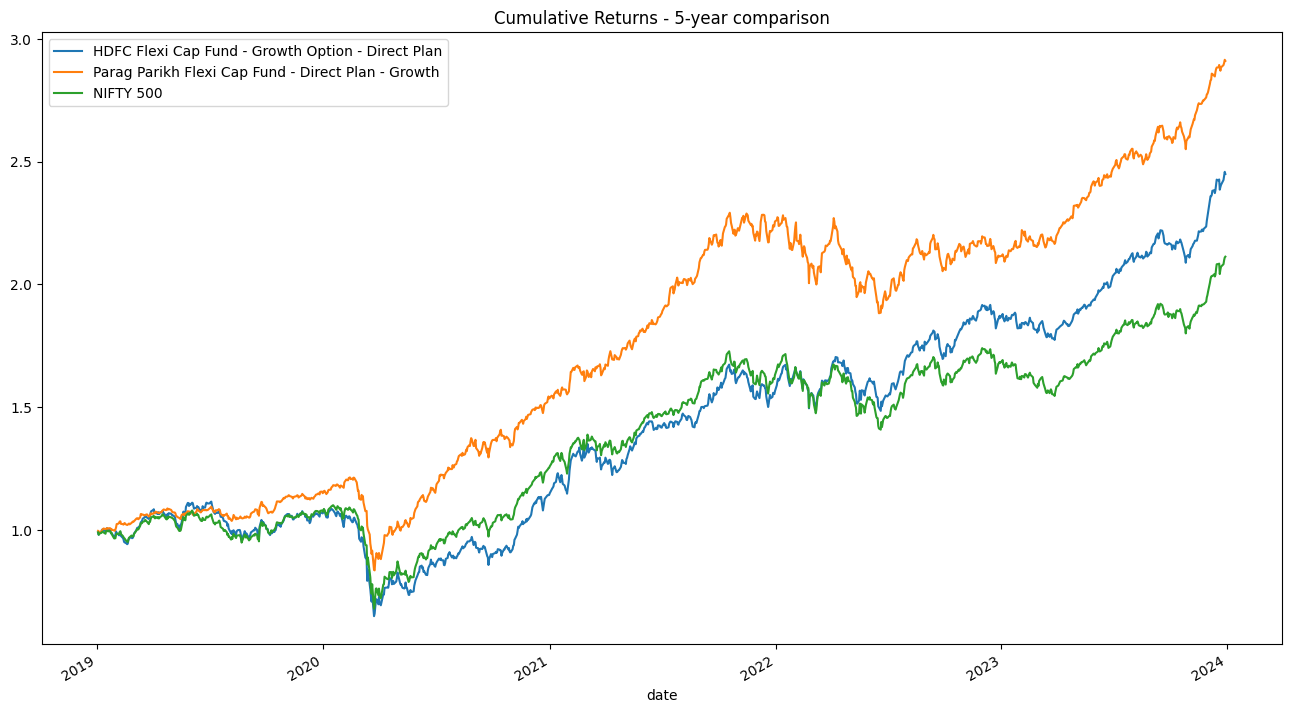

In [19]:
plt.rcParams["figure.figsize"] = [16,9]
time_period = 5

for idx, (instrument_desc, instrument_data) in enumerate(time_period_dataframes[time_period].items()):
    if idx == 0:
        ax = instrument_data.plot(y='cumulative_daily_returns', x='date', label=instrument_desc)
    else:
        instrument_data.plot(ax = ax, y='cumulative_daily_returns', x='date', label=instrument_desc)
        
index = "NIFTY 500"
index_df = time_period_nifty_dataframes[time_period][index]
index_df.plot(ax = ax, y='cumulative_daily_returns', x='date', label=index)

plt.title(f"Cumulative Returns - {time_period}-year comparison")
ax.legend(loc='upper left')
plt.plot()

### Findings: 

1. Both funds have high had higher returns than the benchmark
2. 3yr performance of HDFC flexi cap is superior but it lags in 5 yr time frame
3. Interesting to note that Abs_returns_prcnt_2 < Abs_returns_prcnt_1 for Parag Parikh fund. This shows that the fund struggled in 2022. 


## 2. Performance at an individual year level (or annual return across years)

While the above graphs show the funds performance across the years, we can do a deep-dive analysis for fund's performance for each individual year. We will try to answer the following questions: 
1. How has the fund performed each year based on annual returns?
2. Has the fund consistently beaten the benchmark?

### 2.1.How has the fund performed each year?

This shows if the fund was able to sustain the high performance or it dipped in certain years. The index will also be plotted simultaneously so as to show if the overall market dipped.  What was the fund's growth in 2022 compared to the fund's growth in 2021? 

In [83]:
time_periods = {
    2023: ('1-1-2023', '31-12-2023'), 
    2022: ('1-1-2022', '31-12-2022'),
    2021: ('1-1-2021', '31-12-2021'),
    2020: ('1-1-2020', '31-12-2020'),
    2019: ('1-1-2019', '31-12-2019'),
}

mf_results = []
time_period_dataframes = {time_period: dict() for time_period in time_periods}

# Mutual Funds data
mutual_funds_subset = [
 'HDFC Flexi Cap Fund - Growth Option - Direct Plan',
 'Parag Parikh Flexi Cap Fund - Direct Plan - Growth',
]

for instrument_desc in mutual_funds_subset: 
    for time_period, (starting_date, ending_date) in time_periods.items():
        n_years = time_period
        mutual_fund_data = mf_data_dict[instrument_desc].copy(deep=True)
        mf_with_cumulative = get_cumulative_returns(mutual_fund_data, 
                                                           nav_col='nav', 
                                                           date_col='date',
                                                           starting_date=starting_date, 
                                                           ending_date =ending_date)
        absolute_returns_prcnt = (mf_with_cumulative['cumulative_daily_returns'].values[-1] - 1) * 100

        time_period_dataframes[time_period][instrument_desc] = mf_with_cumulative
        mf_results += [(instrument_desc, time_period, absolute_returns_prcnt)]
        

## Indices cumulative returns and growth 
nifty_indices = ["NIFTY 500",]
nifty_indices_results = []
time_period_nifty_dataframes = {time_period: dict() for time_period in time_periods}


for index in nifty_indices:
    print(index)
    for time_period, (starting_date, ending_date) in time_periods.items():
        n_years = time_period
        index_df = nifty_indices_df_dict[index].copy(deep=True)
        index_with_cumulative = get_cumulative_returns(index_df, 
                                                           nav_col='CLOSE', 
                                                           date_col='date',
                                                           starting_date=starting_date, 
                                                           ending_date=ending_date)
        absolute_returns_prcnt = (index_with_cumulative['cumulative_daily_returns'].values[-1] - 1) * 100

        time_period_nifty_dataframes[time_period][index] = index_with_cumulative
        nifty_indices_results += [(index, time_period, absolute_returns_prcnt)]

NIFTY 500


In [84]:
mf_result_df = pd.DataFrame(mf_results, columns=['Fund', 'Years', 'Abs_returns_prcnt',]).\
pivot(index='Fund', columns='Years', values=['Abs_returns_prcnt',])
mf_result_df.columns = [f'{x}_{y}' for x, y in mf_result_df.columns]
mf_result_df = mf_result_df.applymap(lambda x: f"{x:.2f}%").reset_index()
# mf_result_df

In [85]:
nifty_result_df = pd.DataFrame(nifty_indices_results, columns=['Fund', 'Years', 'Abs_returns_prcnt']).\
pivot(index='Fund', columns='Years', values=['Abs_returns_prcnt'])
nifty_result_df.columns = [f'{x}_{y}' for x, y in nifty_result_df.columns]
nifty_result_df = nifty_result_df.applymap(lambda x: f"{x:.2f}%").reset_index()
nifty_result_df

,Fund,Abs_returns_prcnt_2019,Abs_returns_prcnt_2020,Abs_returns_prcnt_2021,Abs_returns_prcnt_2022,Abs_returns_prcnt_2023
0,NIFTY 500,7.33%,16.48%,29.56%,1.61%,25.16%


In [86]:
results_year_lvl_wide = pd.concat([mf_result_df, nifty_result_df])
results_year_lvl_wide

,Fund,Abs_returns_prcnt_2019,Abs_returns_prcnt_2020,Abs_returns_prcnt_2021,Abs_returns_prcnt_2022,Abs_returns_prcnt_2023
0,HDFC Flexi Cap Fund - Growth Option - Direct Plan,6.68%,6.61%,36.17%,17.29%,30.67%
1,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,14.93%,33.28%,46.76%,-6.51%,37.49%
0,NIFTY 500,7.33%,16.48%,29.56%,1.61%,25.16%


In [87]:
results_year_lvl_long = pd.DataFrame(mf_results + nifty_indices_results, columns=['Fund', 'Year', 'Returns'])
results_year_lvl_long

,Fund,Year,Returns
0,HDFC Flexi Cap Fund - Growth Option - Direct Plan,2023,30.669438
1,HDFC Flexi Cap Fund - Growth Option - Direct Plan,2022,17.287922
2,HDFC Flexi Cap Fund - Growth Option - Direct Plan,2021,36.170054
3,HDFC Flexi Cap Fund - Growth Option - Direct Plan,2020,6.613401
4,HDFC Flexi Cap Fund - Growth Option - Direct Plan,2019,6.679891
5,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,2023,37.494568
6,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,2022,-6.513472
7,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,2021,46.756873
8,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,2020,33.275543
9,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,2019,14.930554


In [88]:
results_wide_dict['year_lvl'] = results_year_lvl_wide
results_long_dict['year_lvl'] = results_year_lvl_long

[]

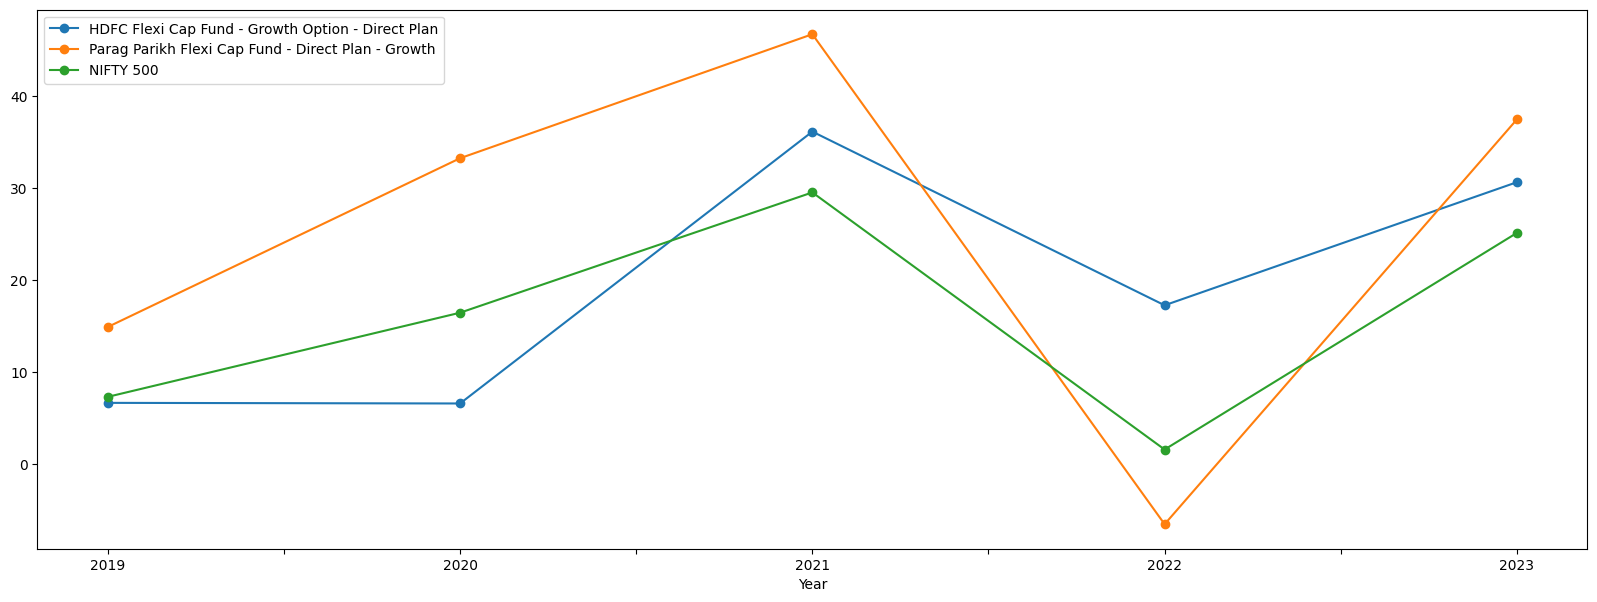

In [89]:
plt.rcParams["figure.figsize"] = [20,7]

def df_process(df):
    df = df.sort_values('Year')
    df['Year'] = df['Year'].astype(str)
    return df

for idx, fund in enumerate(results_year_lvl_long['Fund'].unique()):
    fund_df = results_year_lvl_long.loc[results_year_lvl_long['Fund']==fund]
    fund_df = df_process(fund_df)
    if idx==0:
        ax = fund_df.plot(y='Returns', x='Year', label=fund, marker='o',)
    else:
        fund_df.plot(ax=ax, y='Returns', x='Year', label=fund, marker='o',)
    
plt.legend(loc='upper left')

plt.plot()

### Finding
1. Parag Parikh has been outperforming the benchmark since 2019 with 2022 being an exception. 
2. HDFC Flexi Cap underperformed the benchmark in 2019 and 2020. However, it has come back stronger in 2022 and 2023.

### 2.2 Has the fund consistently beaten the benchmark?

Considering annual returns across 5 years, how many years was the fund able to beat the benchmark? 

If a fund is surpassing the benchmark each year, it means the fund is doing extremely well. 

In [92]:
nifty_results_long = pd.DataFrame(nifty_indices_results, columns=['Index', 'Years', 'Abs_returns_prcnt'])
funds_results_long = pd.DataFrame(mf_results, columns=['Fund', 'Years', 'Abs_returns_prcnt',])

In [90]:
funds_benchmark_mapping = {
 'HDFC Flexi Cap Fund - Growth Option - Direct Plan': "NIFTY 500",
 'Parag Parikh Flexi Cap Fund - Direct Plan - Growth': "NIFTY 500",}

mapping_df = pd.DataFrame(list(funds_benchmark_mapping.items()), columns=['Fund', 'Index'])
mapping_df

,Fund,Index
0,HDFC Flexi Cap Fund - Growth Option - Direct Plan,NIFTY 500
1,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,NIFTY 500


In [93]:
fund_benchmark_yr_lvl = funds_results_long.merge(mapping_df, on='Fund').\
                                        merge(nifty_results_long, on=['Index', 'Years'], suffixes=['_fund', '_index'])
fund_benchmark_yr_lvl['outperform_index'] = np.where(fund_benchmark_yr_lvl['Abs_returns_prcnt_fund'] >= fund_benchmark_yr_lvl['Abs_returns_prcnt_index'], 
                                                           1, 0)
fund_benchmark_yr_lvl.sort_values(['Fund', 'Years'])

,Fund,Years,Abs_returns_prcnt_fund,Index,Abs_returns_prcnt_index,outperform_index
8,HDFC Flexi Cap Fund - Growth Option - Direct Plan,2019,6.679891,NIFTY 500,7.334826,0
6,HDFC Flexi Cap Fund - Growth Option - Direct Plan,2020,6.613401,NIFTY 500,16.481183,0
4,HDFC Flexi Cap Fund - Growth Option - Direct Plan,2021,36.170054,NIFTY 500,29.558482,1
2,HDFC Flexi Cap Fund - Growth Option - Direct Plan,2022,17.287922,NIFTY 500,1.606422,1
0,HDFC Flexi Cap Fund - Growth Option - Direct Plan,2023,30.669438,NIFTY 500,25.158387,1
9,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,2019,14.930554,NIFTY 500,7.334826,1
7,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,2020,33.275543,NIFTY 500,16.481183,1
5,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,2021,46.756873,NIFTY 500,29.558482,1
3,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,2022,-6.513472,NIFTY 500,1.606422,0
1,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,2023,37.494568,NIFTY 500,25.158387,1


In [101]:
fund_benchmarking = fund_benchmark_yr_lvl.groupby(['Fund', 'Index']).agg({'outperform_index': ['sum', 'count']})
fund_benchmarking.columns = [f'{x}_{y}' for x, y in fund_benchmarking.columns]
fund_benchmarking = fund_benchmarking.reset_index()
fund_benchmarking

,Fund,Index,outperform_index_sum,outperform_index_count
0,HDFC Flexi Cap Fund - Growth Option - Direct Plan,NIFTY 500,3,5
1,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,NIFTY 500,4,5


## 3. Combining the above metrics and presenting the final results

I will combine the results from 1.2 and 2.2.  

I chose 1.2 over 1.1 because I wanted to focus on recency and the 5-yr returns were same for both 1.1 and 1.2. Additionally, the benchmark outperformance count will explain some of the deviation in the returns variability between the two funds. 

If, however, a further deep-dive is needed then the annual returns across years and its comparison with benchmark can always be accessed.

In [110]:
final_result = result_df.reset_index().merge(fund_benchmarking, on='Fund')

In [111]:
final_result.T

,0,1
Fund,HDFC Flexi Cap Fund - Growth Option - Direct Plan,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...
Abs_returns_prcnt_1,30.67%,37.49%
Abs_returns_prcnt_2,54.18%,28.68%
Abs_returns_prcnt_3,113.16%,89.30%
Abs_returns_prcnt_4,128.64%,152.66%
Abs_returns_prcnt_5,144.90%,190.97%
CAGR_1,30.67%,37.49%
CAGR_2,24.17%,13.44%
CAGR_3,28.70%,23.70%
CAGR_4,22.97%,26.08%


## Conclusion

If someone favours long-term performance then Parag Parikh has an edge over HDFC Flexi Cap. 

That being said HDFC flexi cap has also given decent returns over the 5-yr period and if one were to invest giving higher priority to last two years performance than HDFC Flexi cap is the winner.

Note that volatility measures have not been added to the above analysis. It will add another dimension to the analysis and fund selection.